## Import libraries

In [7]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import seaborn as sns

## Visualize the data

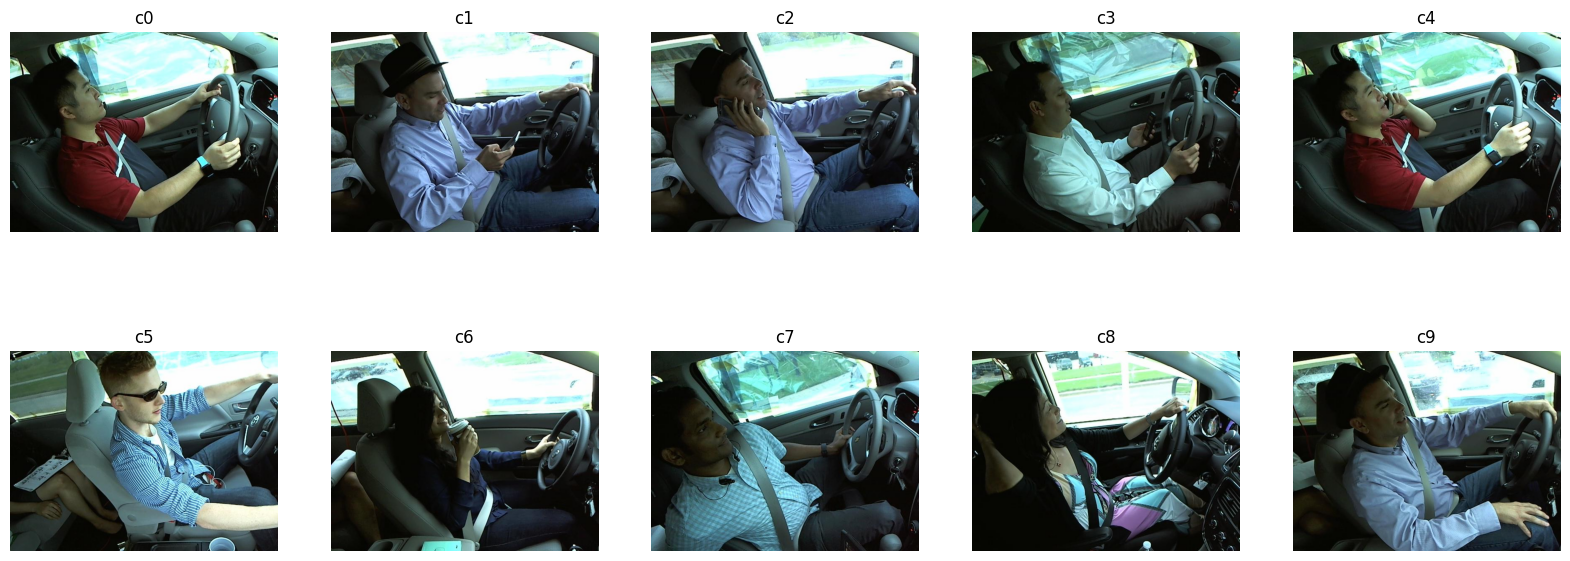

In [3]:
TRAIN_DIR = "/localhome/zapp_an/Desktop/kaggle_projects/local_trials/distracted_driver/imgs/train/"
labels = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

#randomly selecting one image per class

img_c0_path = TRAIN_DIR + "c0/" + random.choice(os.listdir(TRAIN_DIR + "c0/"))
img_c1_path = TRAIN_DIR + "c1/" + random.choice(os.listdir(TRAIN_DIR + "c1/"))
img_c2_path = TRAIN_DIR + "c2/" + random.choice(os.listdir(TRAIN_DIR + "c2/"))
img_c3_path = TRAIN_DIR + "c3/" + random.choice(os.listdir(TRAIN_DIR + "c3/"))
img_c4_path = TRAIN_DIR + "c4/" + random.choice(os.listdir(TRAIN_DIR + "c4/"))
img_c5_path = TRAIN_DIR + "c5/" + random.choice(os.listdir(TRAIN_DIR + "c5/"))
img_c6_path = TRAIN_DIR + "c6/" + random.choice(os.listdir(TRAIN_DIR + "c6/"))
img_c7_path = TRAIN_DIR + "c7/" + random.choice(os.listdir(TRAIN_DIR + "c7/"))
img_c8_path = TRAIN_DIR + "c8/" + random.choice(os.listdir(TRAIN_DIR + "c8/"))
img_c9_path = TRAIN_DIR + "c9/" + random.choice(os.listdir(TRAIN_DIR + "c9/"))

# reading the images
imgs = {}

imgs["c0"] = cv2.cvtColor(cv2.imread(img_c0_path), cv2.COLOR_BGR2RGB)
imgs["c1"] = cv2.cvtColor(cv2.imread(img_c1_path), cv2.COLOR_BGR2RGB)
imgs["c2"] = cv2.cvtColor(cv2.imread(img_c2_path), cv2.COLOR_BGR2RGB)
imgs["c3"] = cv2.cvtColor(cv2.imread(img_c3_path), cv2.COLOR_BGR2RGB)
imgs["c4"] = cv2.cvtColor(cv2.imread(img_c4_path), cv2.COLOR_BGR2RGB)
imgs["c5"] = cv2.cvtColor(cv2.imread(img_c5_path), cv2.COLOR_BGR2RGB)
imgs["c6"] = cv2.cvtColor(cv2.imread(img_c6_path), cv2.COLOR_BGR2RGB)
imgs["c7"] = cv2.cvtColor(cv2.imread(img_c7_path), cv2.COLOR_BGR2RGB)
imgs["c8"] = cv2.cvtColor(cv2.imread(img_c8_path), cv2.COLOR_BGR2RGB)
imgs["c9"] = cv2.cvtColor(cv2.imread(img_c9_path), cv2.COLOR_BGR2RGB)

# displaying the images
display_rows = 5
display_columns = 5
fig = plt.figure(figsize=(20, 20))

for label, index in zip(labels, range(10)):
    fig.add_subplot(display_rows, display_columns, index + 1)
    plt.imshow(imgs[label])
    plt.axis('off')
    plt.title(label)


## Data distribution

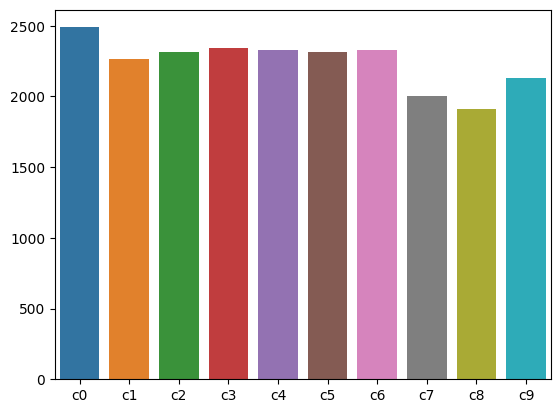

In [8]:
samples = {}
for label in labels:
    samples[label] = [len(os.listdir(TRAIN_DIR + label + "/"))]

samples_df = pd.DataFrame.from_dict(samples)
sns.barplot(data = samples_df)
plt.show()

## Hyperparameters

In [10]:
batch_size = 32
base_learning_rate = 0.001
base_momentum=0.9
initial_epochs = 15
fine_tune_epochs = 10
fine_tune_at = 4
drop_out_rate = 0.2
initial_patience = 3
fine_tune_patience = 2


## Data loading and augmentation

In [4]:
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
BASE_MODEL_LAYER = 1

preprocess_input = tf.keras.applications.resnet50.preprocess_input

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

training_dataset = data_augmentation.flow_from_directory(TRAIN_DIR,
                                                        subset="training",
                                                        seed=123,
                                                        target_size=IMG_SIZE,
                                                        batch_size=batch_size,
                                                        class_mode='sparse')
validation_dataset = data_augmentation.flow_from_directory(TRAIN_DIR,
                                                        subset="validation",
                                                        seed=123,
                                                        target_size=IMG_SIZE,
                                                        batch_size=batch_size,
                                                        class_mode='sparse')

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


## Transfer learning with Resnet50

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')
base_model.trainable = False
inputs = tf.keras.Input(shape=IMG_SHAPE)

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(drop_out_rate)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

initial_optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate,
                                            momentum=base_momentum)

model.compile(optimizer=initial_optimizer,
              loss=loss_function,
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=initial_patience, restore_best_weights=True)

model.fit(training_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks=[es])
#model.save('transfer_learning_model.keras')

## Fine tuning

In [ ]:
base_model = model.layers[BASE_MODEL_LAYER]
base_model.trainable = True

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

fine_tuning_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001 * base_learning_rate)
metrics=['accuracy']

model.compile(loss=loss_function,
              optimizer = fine_tuning_optimizer,
              metrics=metrics)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=fine_tune_patience, restore_best_weights=True)

history_fine = model.fit(training_dataset,
                         epochs=fine_tune_epochs,
                         validation_data=validation_dataset,
                         callbacks=[es])

#model.save('fine_tuned_model.keras')

## Produce submission.csv

In [ ]:
test_path = '../imgs/test/'
submission_df = pd.DataFrame(columns=['img','c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'])

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

test_dataset = test_datagen.flow_from_directory(
    directory='../imgs/',
    target_size=IMG_SIZE,
    batch_size=32,
    classes=['test'],
    class_mode=None,
    shuffle=False
)

# Get filenames and predictions
file_names = sorted(os.listdir(test_path))
len(file_names)

predictions = model.predict(test_dataset, verbose=1)

file_names, predictions = zip(*sorted(zip(file_names, predictions.tolist())))

# Vectorized concatenation of file names with predictions
arr = np.column_stack([file_names, predictions])

# Append image file name with its prediction as a record in the DataFrame
submission_df = pd.concat([submission_df, pd.DataFrame(arr)], axis=1)
submission_df.to_csv('./submission.csv', index=False)